In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import least_squares
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import norm
from scipy.interpolate import interp1d
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
mpl.rcParams.update({'font.size':10})

psth_bins = np.arange(-200,401)
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
kcolors = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
tcolors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}

import fmEphys as fme
# import fmSaccades as fmsacc

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Loading DLC 2.2.3...


In [2]:
hffm = fme.read_group_h5(r'D:\niell_lab_data\mouse\hffm_021423_figupdate.h5')

In [ ]:
# hffm = fme.read_group_h5(r'D:\niell_lab_data\mouse\hffm_021423_figupdate.h5')

In [4]:
hffm['session'].unique()

array(['020222_J577TT_control_Rig2', '020422_J577RT_control_Rig2',
       '062921_G6HCK1ALTRN_control_Rig2', '070921_J553RT_control_Rig2',
       '101521_J559NC_control_Rig2', '102621_J558NC_control_Rig2',
       '110321_J558LT_control_Rig2', '110421_J569LT_control_Rig2',
       '122021_J581RT_control_Rig2'], dtype=object)

In [13]:
for s in hffm['session'].unique():
    _t = hffm['FmLt_eyeT'][hffm['session']==s].iloc[0]
    print(s)
    print((_t[-1] - _t[0]) / 60)
    print(len(hffm['FmLt_eyeT'][hffm['session']==s].index.values))

020222_J577TT_control_Rig2
48.539785716666664
50
020422_J577RT_control_Rig2
50.062580491666814
130
062921_G6HCK1ALTRN_control_Rig2
43.92494806666679
73
070921_J553RT_control_Rig2
45.30929002499991
128
101521_J559NC_control_Rig2
60.626129283333405
67
102621_J558NC_control_Rig2
63.579917333333285
102
110321_J558LT_control_Rig2
59.13376340833347
35
110421_J569LT_control_Rig2
47.09968000000008
71
122021_J581RT_control_Rig2
45.52719072499992
60


In [3]:
demo = hffm[hffm['session']=='102621_J558NC_control_Rig2'].iloc[0]


PermissionError: [Errno 13] Permission denied: 'dPhi.pdf'

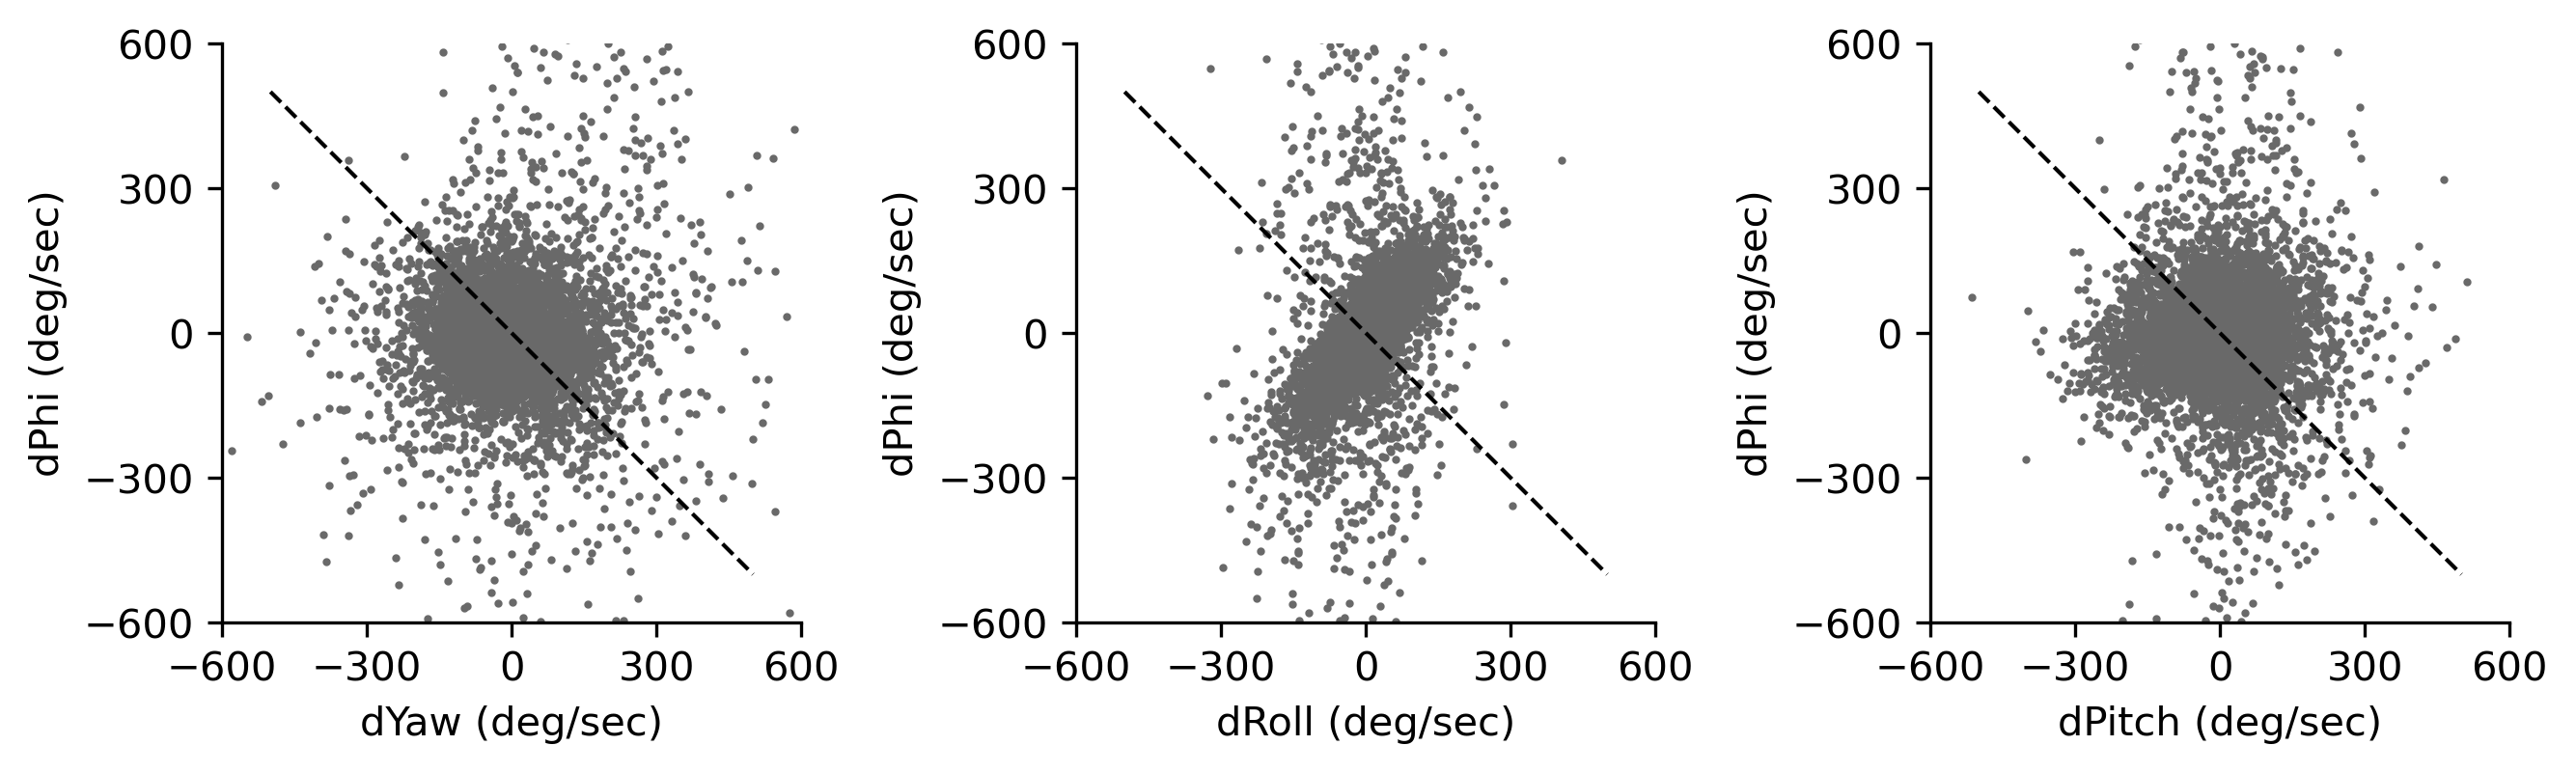

In [5]:

dHead_data = demo['FmLt_dHead']
dEye_data = demo['FmLt_dEye_dps']
dGaze_data = demo['FmLt_dGaze']
eyeT = demo['FmLt_eyeT']

dRoll_data = interp1d(demo['FmLt_imuT'], demo['FmLt_gyro_x'], bounds_error=False)(eyeT)
# dRoll_data = dRoll_data[:-1] / np.diff(eyeT)

dPitch_data = interp1d(demo['FmLt_imuT'], demo['FmLt_gyro_y'], bounds_error=False)(eyeT)
# dPitch_data = dPitch_data[:-1] / np.diff(eyeT)

dPhi_data = np.diff(demo['FmLt_phi']) / np.diff(eyeT)

# left = demo['FmLt_gazeshift_left_saccTimes_dHead1']
# right = demo['FmLt_gazeshift_right_saccTimes_dHead1']
# comp = np.hstack([demo['FmLt_comp_left_saccTimes_dHead1'], demo['FmLt_comp_right_saccTimes_dHead1']])

plotinds = np.sort(np.random.choice(np.arange(eyeT.size), size=int(np.ceil(eyeT.size/25)), replace=False))
# gazemovs = np.hstack([left, right])

fig, [ax_dEyeHead, ax_dPhiRoll, ax_dPitchHead] = plt.subplots(1,3, figsize=(9,3), dpi=300)
for i in plotinds:
    # dGaze_i = np.abs(dHead_data[i]+dEye_data[i])
    # if (eyeT[i] in gazemovs) or (dGaze_i>240):
    #     c = tcolors['gaze']
    # elif (eyeT[i] in comp) or (dGaze_i<120):
    #     c = tcolors['comp']
    # elif (dGaze_i<240) and (dGaze_i>120): 
    #     c = 'dimgray'
    # else:
    #     continue
    ax_dEyeHead.plot(dHead_data[i], dPhi_data[i], '.', color='dimgrey', markersize=2)

    ax_dPitchHead.plot(dPitch_data[i], dPhi_data[i], '.', color='dimgrey', markersize=2)

    # dGaze_i = np.abs(dRoll_data[i]+dPhi_data[i])
    # if dGaze_i>240:
    #     c = tcolors['gaze']
    # elif dGaze_i<120:
    #     c = tcolors['comp']
    # elif (dGaze_i<240) and (dGaze_i>120):
    #     c = 'dimgray'
    # else:
    #     continue
    ax_dPhiRoll.plot(dRoll_data[i], dPhi_data[i], '.', color='dimgrey', markersize=2)

ax_dEyeHead.set_aspect('equal','box')
ax_dEyeHead.set_xlim([-600,600])
ax_dEyeHead.set_ylim([-600,600])
ax_dEyeHead.set_xlabel('dYaw (deg/sec)')
ax_dEyeHead.set_ylabel('dPhi (deg/sec)')
ax_dEyeHead.plot([-500,500],[500,-500], linestyle='dashed', color='k', linewidth=1)
ax_dEyeHead.set_xticks(np.linspace(-600,600,5))
ax_dEyeHead.set_yticks(np.linspace(-600,600,5))

ax_dPitchHead.set_aspect('equal','box')
ax_dPitchHead.set_xlim([-600,600])
ax_dPitchHead.set_ylim([-600,600])
ax_dPitchHead.set_xlabel('dPitch (deg/sec)')
ax_dPitchHead.set_ylabel('dPhi (deg/sec)')
ax_dPitchHead.plot([-500,500],[500,-500], linestyle='dashed', color='k', linewidth=1)
ax_dPitchHead.set_xticks(np.linspace(-600,600,5))
ax_dPitchHead.set_yticks(np.linspace(-600,600,5))

ax_dPhiRoll.set_aspect('equal','box')
ax_dPhiRoll.set_xlim([-600,600])
ax_dPhiRoll.set_ylim([-600,600])
ax_dPhiRoll.set_xlabel('dRoll (deg/sec)')
ax_dPhiRoll.set_ylabel('dPhi (deg/sec)')
ax_dPhiRoll.plot([-500,500],[500,-500], linestyle='dashed', color='k', linewidth=1)
ax_dPhiRoll.set_xticks(np.linspace(-600,600,5))
ax_dPhiRoll.set_yticks(np.linspace(-600,600,5))

fig.tight_layout()
fig.savefig('dPhi.pdf')

In [3]:
def gaus(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

k_list = ['early','late','biphasic','negative']

gaus_fits = {}
gaus_inputs = {
    'early': {},
    'late': {},
    'biphasic': {},
    'negative': {}
}
for k, kname in enumerate(k_list):

    use = hffm[hffm['gazecluster']==kname][hffm['Gt_responsive']==True].copy()

    gaus_fits[kname] = np.zeros([len(use.index.values), 2, 3])
    gaus_inputs[kname]['sf'] = np.zeros([len(use.index.values), 3])
    gaus_inputs[kname]['tf'] = np.zeros([len(use.index.values), 2])

    for i, ind in tqdm(enumerate(use.index.values)):

        row = use.loc[ind]

        sftune = np.array([np.mean(row['norm_ori_tuning_low']),
                        np.mean(row['norm_ori_tuning_mid']),
                        np.mean(row['norm_ori_tuning_high'])])
        sftune = sftune - row['Gt_drift_spont']
        sftune[sftune < 0] = 0
        sftune = sftune / np.nanmax(sftune)
        
        tuning = np.nanmean(row['Gt_ori_tuning_tf'],1)
        tuning = tuning - row['Gt_drift_spont']
        tuning[tuning < 0] = 0
        tftune = np.array([np.mean(tuning[:,0]),
                                np.mean(tuning[:,1])])
        tftune = tftune / np.nanmax(tftune)

        if np.isnan(sftune).any() or np.isnan(tftune).any():
            continue
        
        popt, pcov = curve_fit(gaus, np.arange(0,3,1), sftune,
                           p0=[1., 1., 2.],
                           method='trf',
                           xtol=1e-8,
                           ftol=1e-8,
                           gtol=1e-8,
                        #    tr_solver='exact',
                           max_nfev=70000)
        
        gaus_fits[kname][i,0,:] = popt
        
        popt, pcov = curve_fit(gaus, np.arange(0,2,1), tftune,
                           p0=[1., 0.5, 3.],
                           method='trf',
                           xtol=1e-8,
                           ftol=1e-8,
                           gtol=1e-8,
                        #    tr_solver='exact',
                           max_nfev=70000)
        
        gaus_fits[kname][i,1,:] = popt

        gaus_inputs[kname]['sf'][i,:] = sftune
        gaus_inputs[kname]['tf'][i,:] = tftune
        
        


71it [00:18,  3.79it/s]
96it [00:28,  3.42it/s]
98it [00:20,  4.68it/s]
29it [00:05,  5.74it/s]


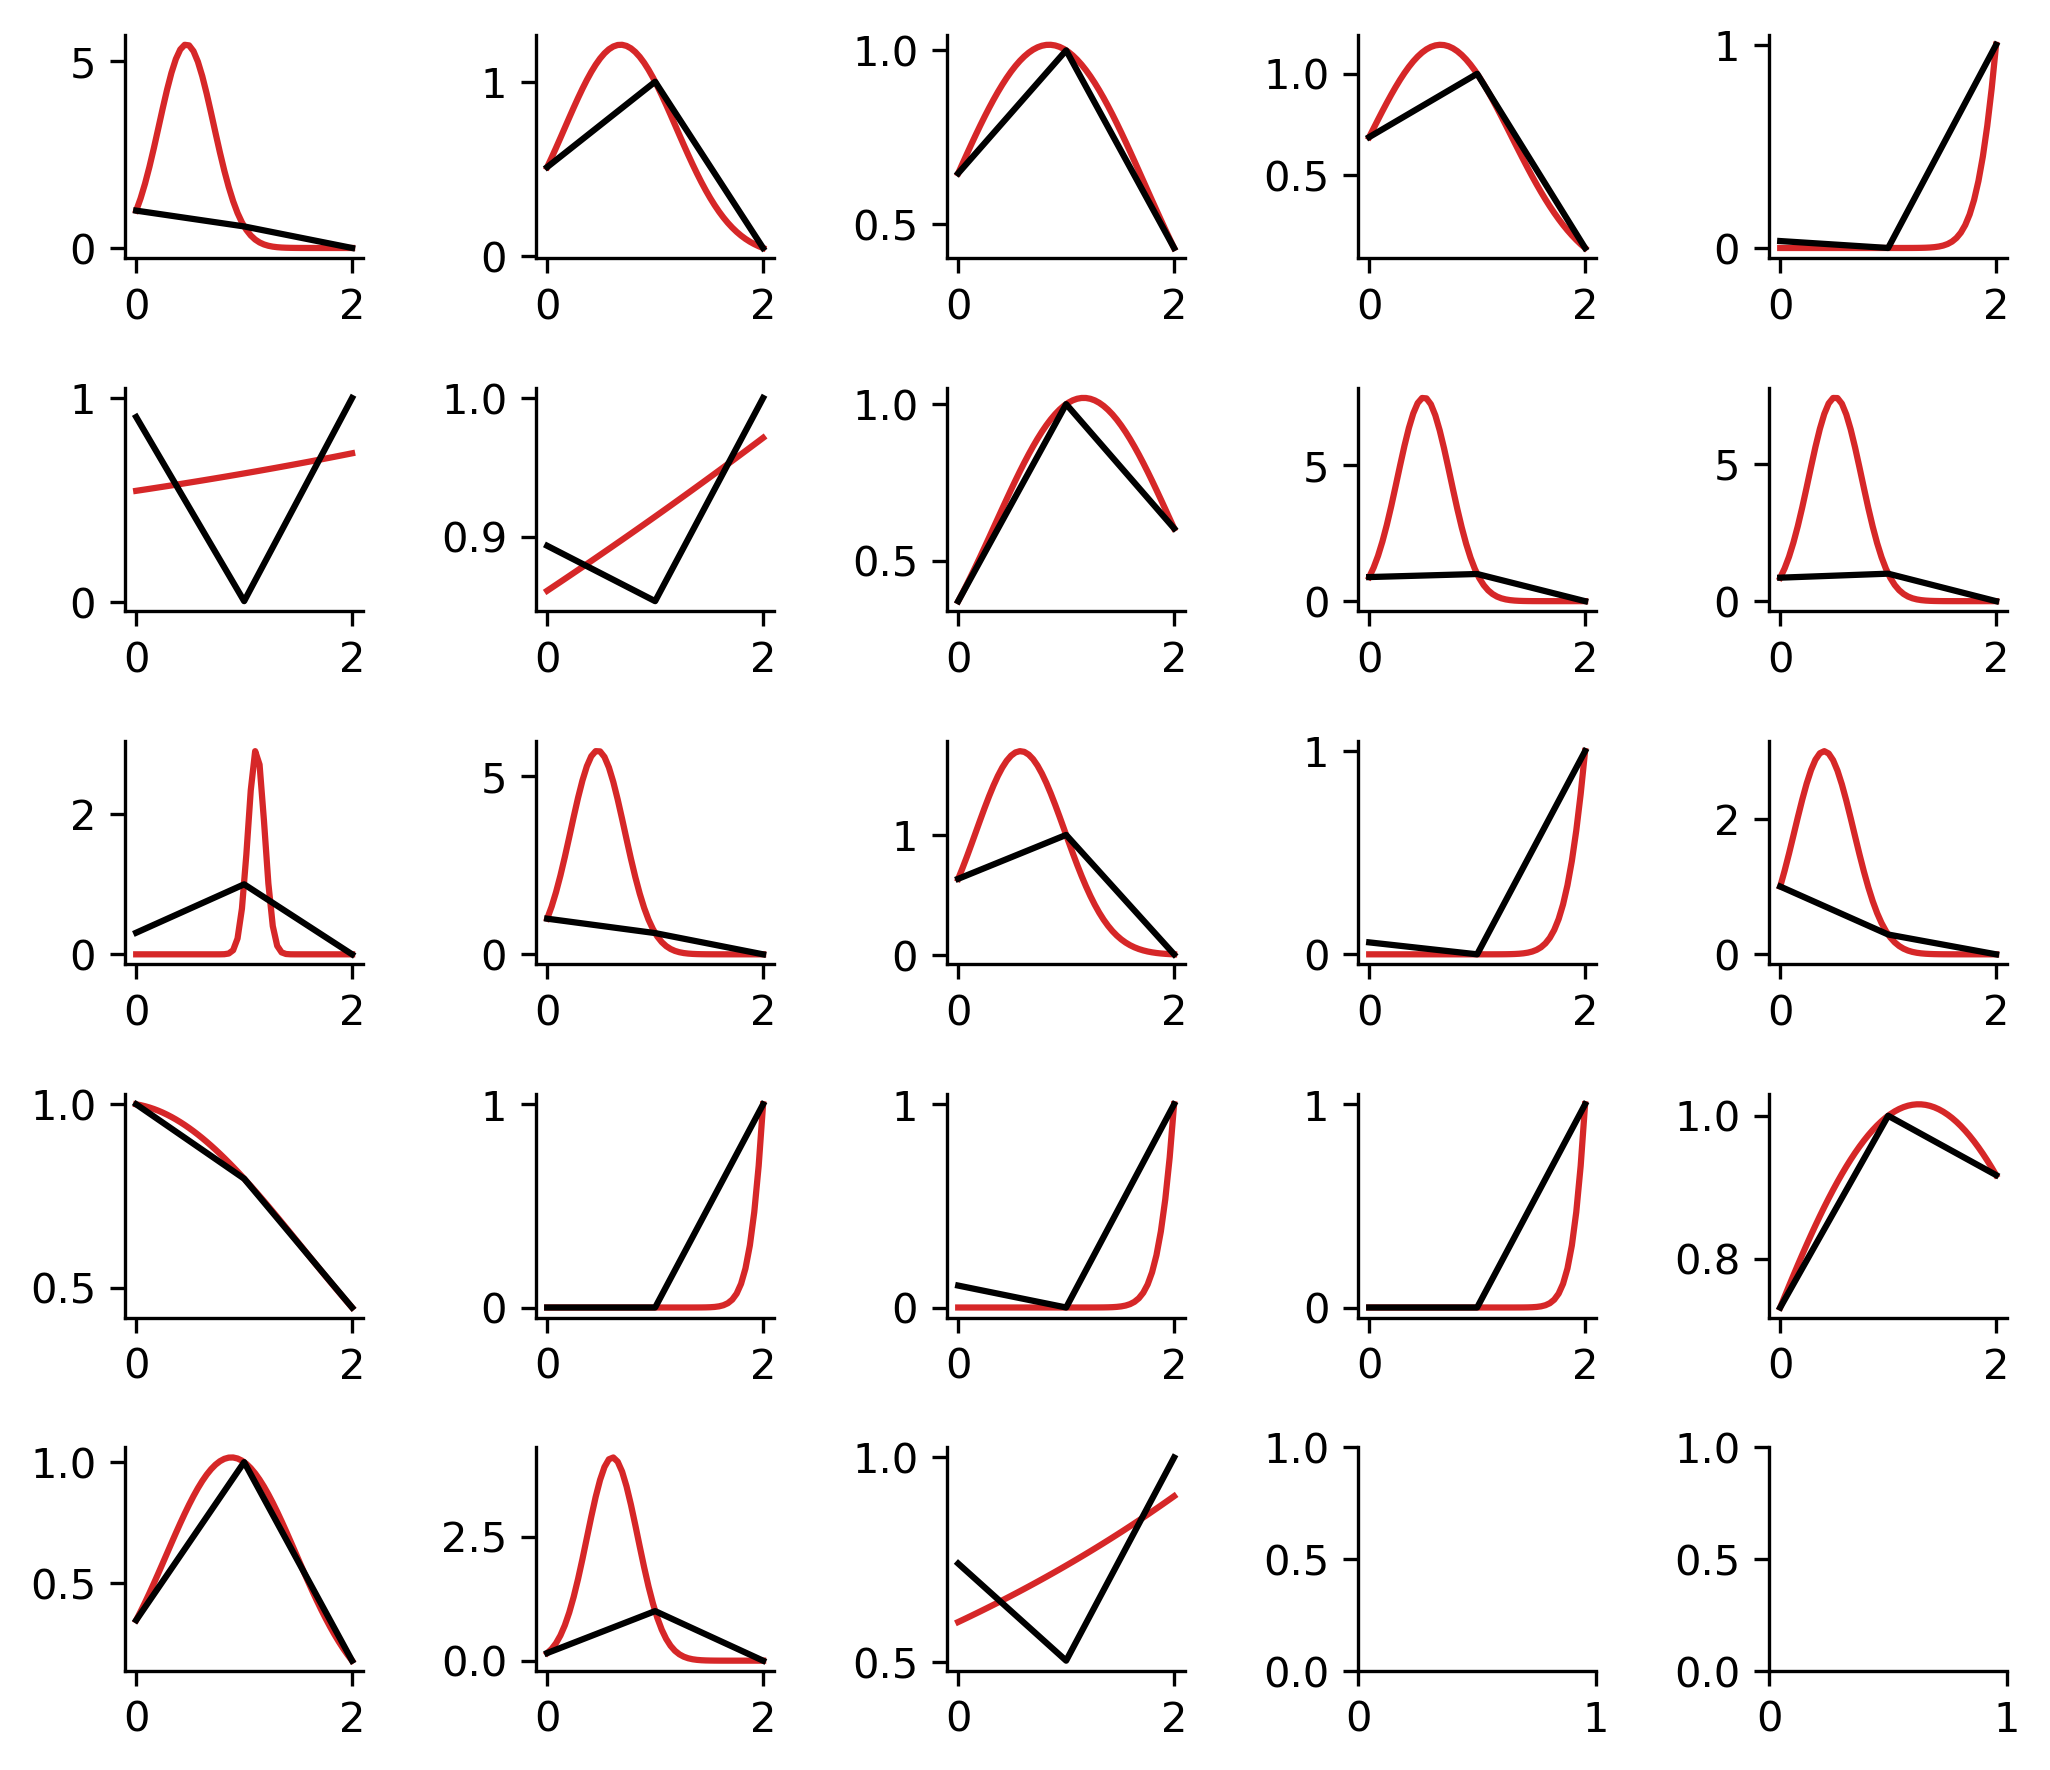

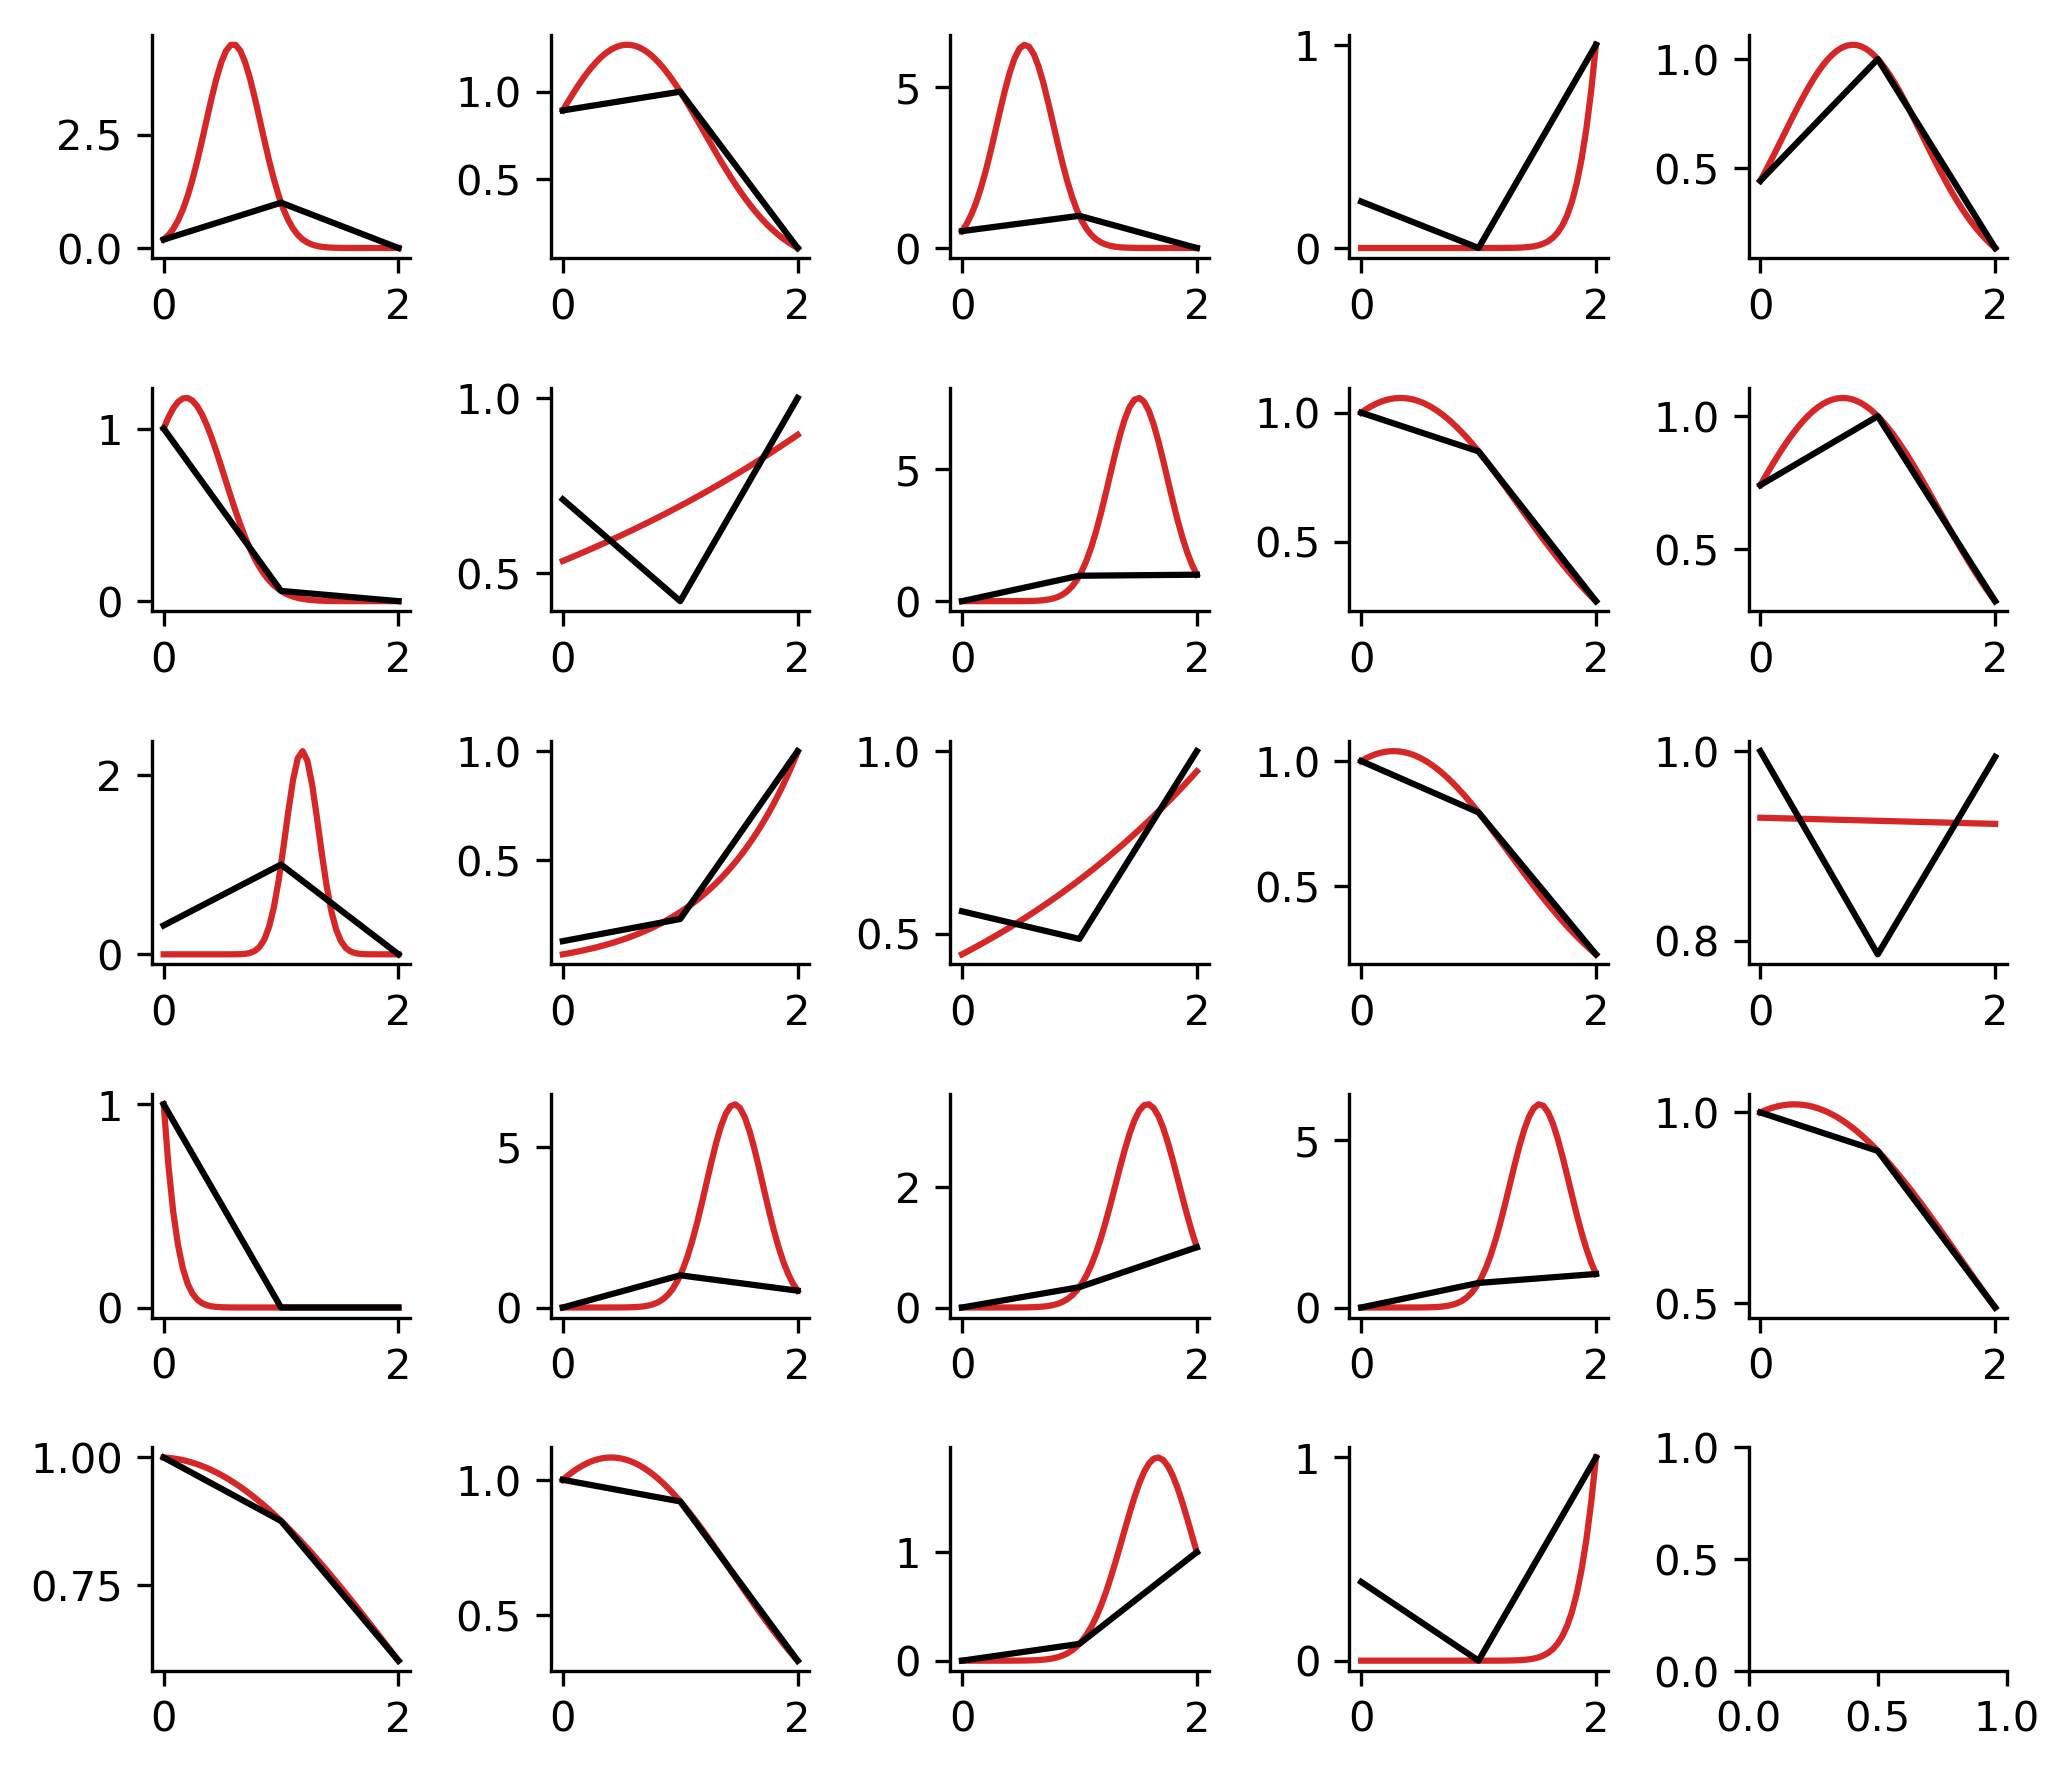

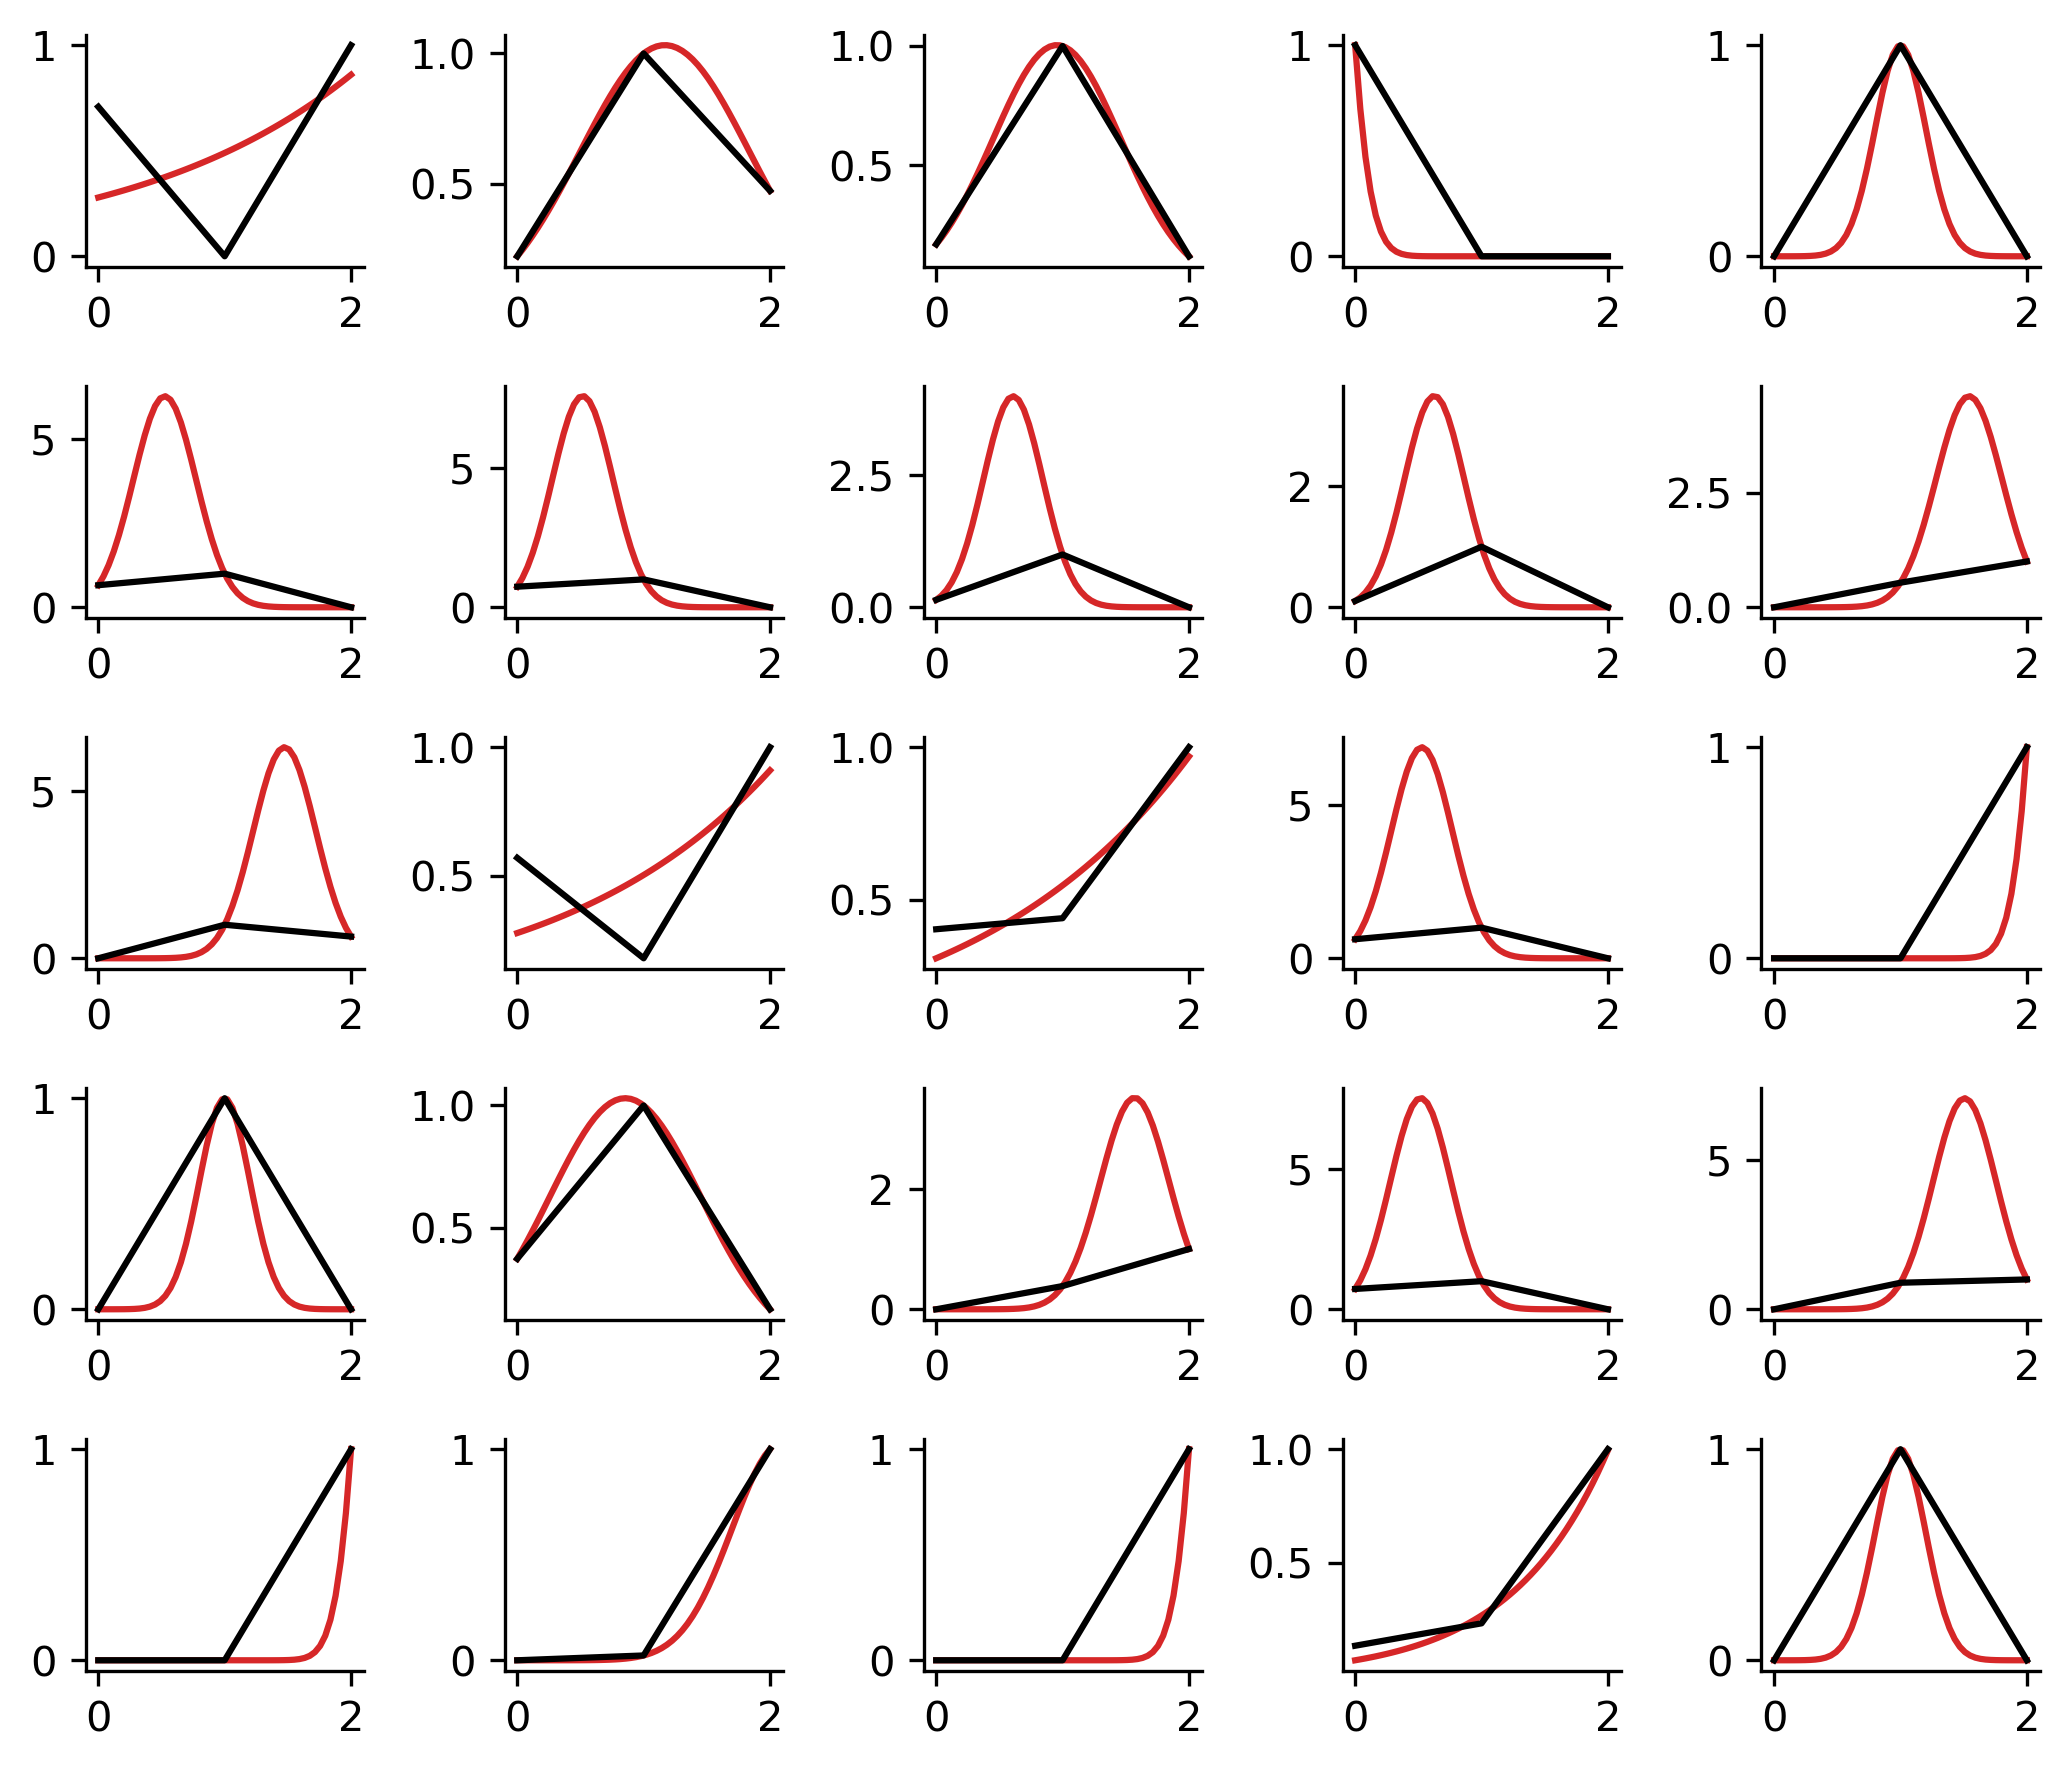

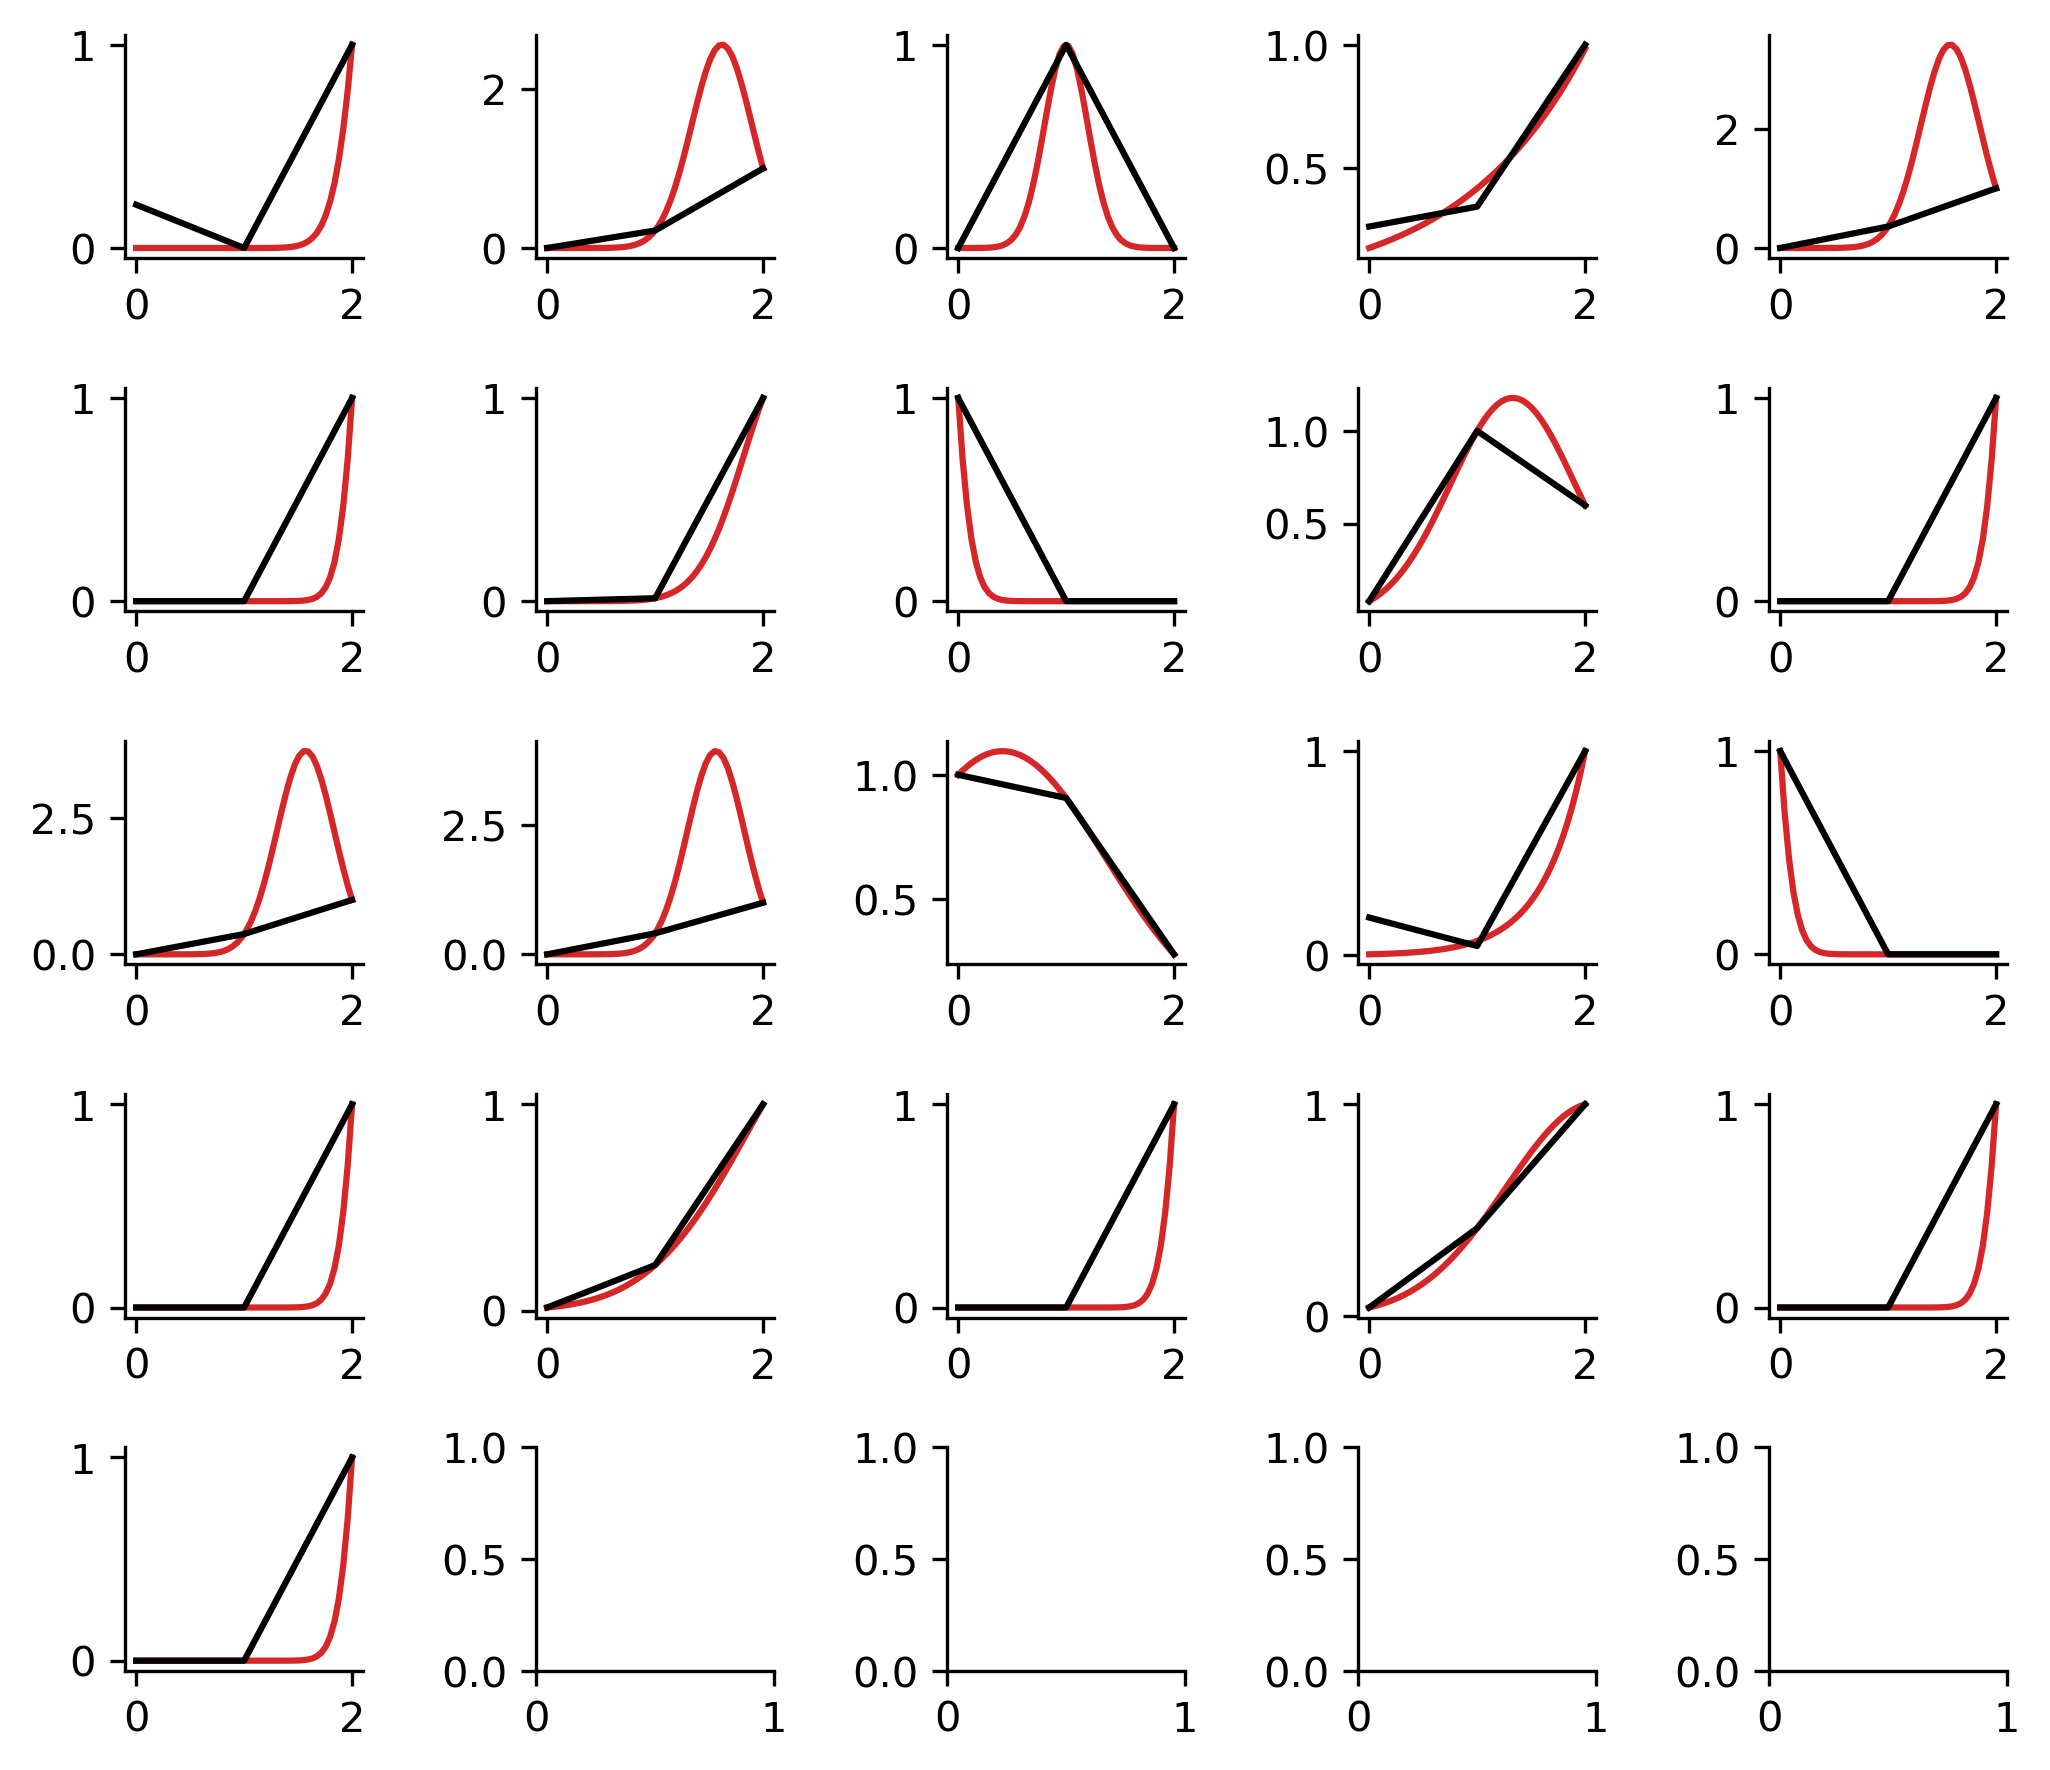

In [36]:

for k, kname in enumerate(['early','late','biphasic','negative']):

    fig, axs = plt.subplots(5,5, figsize=(7,6), dpi=300)
    axs = axs.flatten()

    p = 0

    for i in range(25):

        if np.max(gaus_inputs[kname]['tf'][i,:])==0:
            continue

        axs[p].plot(np.linspace(0,2), gaus(np.linspace(0,2), *list(gaus_fits[kname][i,0,:])),
                    color='tab:red', label='sf')
        # axs[p].plot(np.linspace(0,1), gaus(np.linspace(0,1), *list(gaus_fits[kname][i,1,:])),
        #             color='tab:red', alpha=0.5, label='tf')
        
        axs[p].plot([0,1,2], gaus_inputs[kname]['sf'][i,:],
                    color='k')
        # axs[p].plot([0,1], gaus_inputs[kname]['tf'][i,:],
        #             color='tab:orange', alpha=0.5)
        
        p += 1
    fig.tight_layout()
    fig.savefig('{}_gauss_fits.pdf'.format(kname))


        




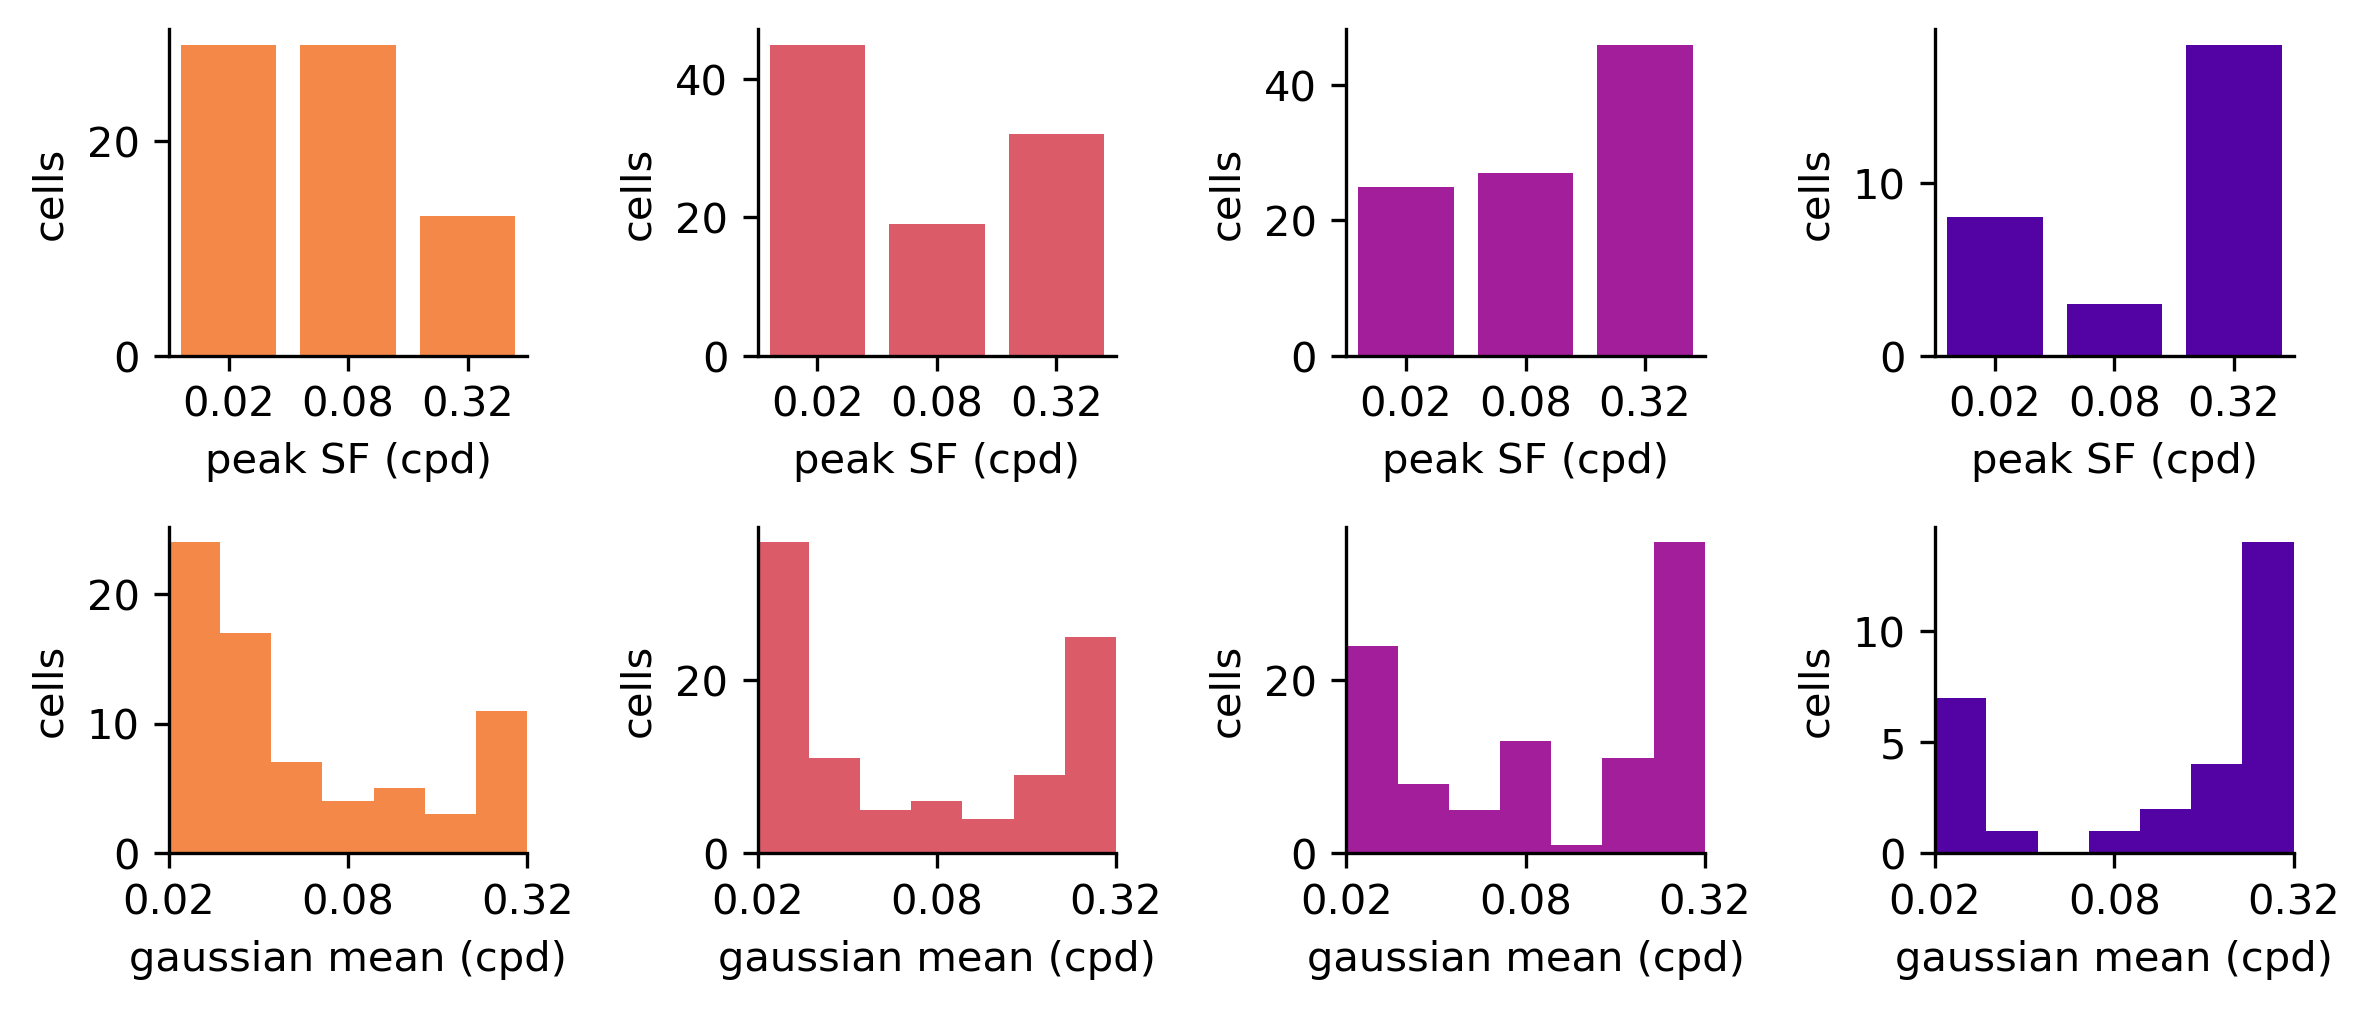

In [37]:
fig, axs = plt.subplots(2,4, figsize=(8,3.5), dpi=300)

for k, kname in enumerate(k_list):

    ax = axs[1,k]
    
    _show_means = gaus_fits[kname][:,0,1].copy()
    _show_means[_show_means<0] = 0
    _show_means[_show_means>2] = 2

    ax1 = axs[0,k]
    peak_vals = gaus_inputs[kname]['sf'].copy()
    peak_vals = [np.nanargmax(x) for x in peak_vals]
    _vals, _counts = np.unique(peak_vals, return_counts=True)
    # print(kname, _vals, _counts, np.sum(_counts))
    _valcounts = dict(zip(_vals, _counts))
    for k,v in _valcounts.items():
        ax1.bar(k,v, color=kcolors[kname])
    ax1.set_xlim([-.5,2.5])
    ax1.set_xticks([0,1,2], labels=['0.02', '0.08', '0.32'])
    ax1.set_ylabel('cells')
    ax1.set_xlabel('peak SF (cpd)')
    
    ax.hist(_show_means, bins=np.linspace(0,2,8), color=kcolors[kname])
    # ax.set_title(kname)

    ax.set_xlim([0,2])
    ax.set_ylabel('cells')
    if k>1:
        ax.set_xlabel('gaussian mean (cpd)')
        ax.set_xticks([0,1,2], labels=['0.02', '0.08', '0.32'])
    else:
        ax.set_xticks([0,1,2], labels=[])
    # ax.set_ylim([0,30])

    

fig.tight_layout()
fig.savefig('mouse_gauss_means.pdf')


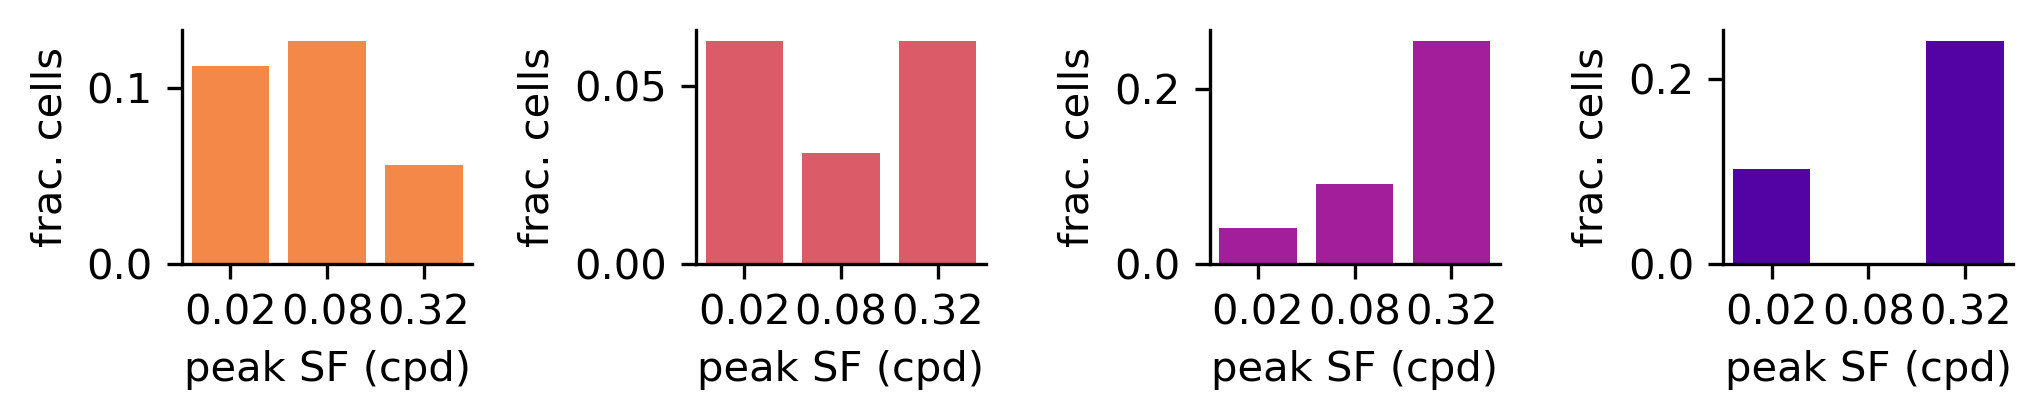

In [20]:
fig, axs = plt.subplots(1,4, figsize=(7,1.5), dpi=300)

k_list = ['early','late','biphasic','negative']

for k, kname in enumerate(k_list):

    use_hf = hffm[hffm['gazecluster']==kname][hffm['Gt_responsive']==True].copy()

    sf_responses = np.zeros([len(use_hf.index.values),6])*np.nan
    
    for i, ind in enumerate(use_hf.index.values):
        row = use_hf.loc[ind]
        orientations = np.nanmean(np.array(row['Gt_ori_tuning_tf'], dtype=np.float),2)
        for sfnum in range(3):
            sf = ['low','mid','high'][sfnum]
            hffm.at[ind,'norm_ori_tuning_'+sf] = orientations[:,sfnum] - row['Gt_drift_spont']
        sf_responses[i,:3] = np.array([np.nanmean(hffm.at[ind,'norm_ori_tuning_low']),
                                       np.nanmean(hffm.at[ind,'norm_ori_tuning_mid']),
                                       np.nanmean(hffm.at[ind,'norm_ori_tuning_high'])])

    for i in range(np.size(sf_responses,0)):
        _l = sf_responses[i,0]
        _m = sf_responses[i,1]
        _h = sf_responses[i,2]
        sf_responses[i,3] = _l/(_m+_h)
        sf_responses[i,4] = _m/(_l+_h)
        sf_responses[i,5] = _h/(_l+_m)

    num_low_pref = len(use_hf.index.values[sf_responses[:,3]>2.0]) / len(use_hf.index)
    num_mid_pref = len(use_hf.index.values[sf_responses[:,4]>2.0]) / len(use_hf.index)
    num_high_pref = len(use_hf.index.values[sf_responses[:,5]>2.0]) / len(use_hf.index)
    
    use_counts = np.array([num_low_pref, num_mid_pref, num_high_pref])

    # use_counts[0] = len(use_hf.index.values[sf_responses[:,3]>2.0])
    # use_counts[1] = len(use_hf.index.values[sf_responses[:,4]>2.0])
    # use_counts[2] = len(use_hf.index.values[sf_responses[:,5]>2.0])

    # total_cells = np.ones(3)*len(use_hf.index.values)

    axs[k].bar(range(3), use_counts, color=kcolors[kname])
    axs[k].set_xlim([-.5,2.5])
    axs[k].set_xticks([0,1,2], labels=['0.02', '0.08', '0.32'])
    axs[k].set_ylabel('frac. cells')
    axs[k].set_xlabel('peak SF (cpd)')

fig.tight_layout()
fig.savefig('mouse_sf_pref_bars.pdf')

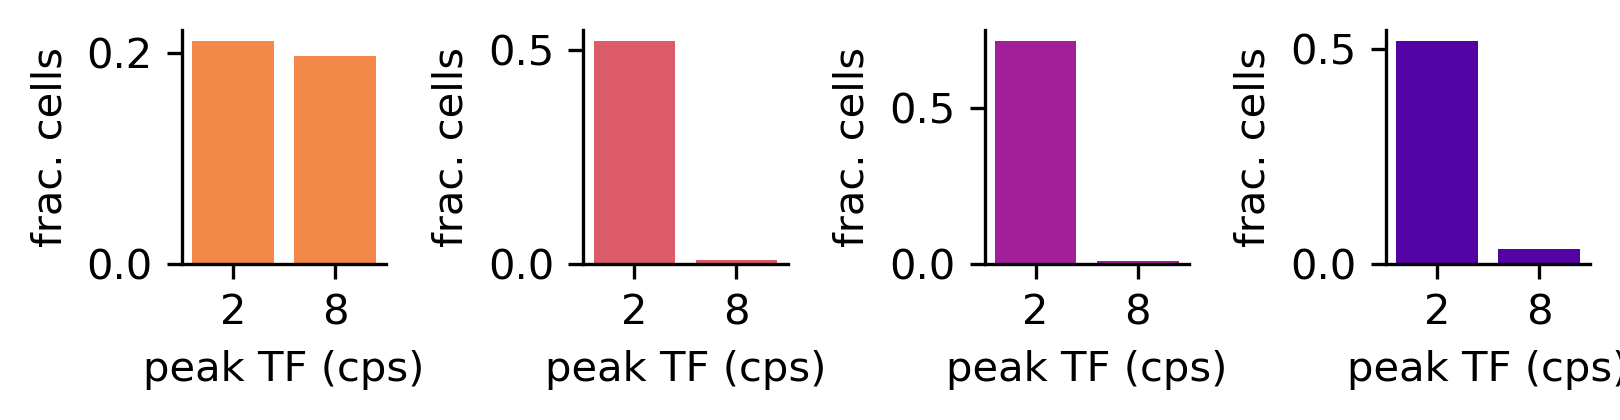

In [10]:
fig, axs = plt.subplots(1,4, figsize=(5.5,1.5), dpi=300)

k_list = ['early','late','biphasic','negative']

for k, kname in enumerate(k_list):

    use_hf = hffm[hffm['gazecluster']==kname][hffm['Gt_responsive']==True].copy()

    tf_responses = np.zeros([len(use_hf.index.values),4])*np.nan
    
    for i, ind in enumerate(use_hf.index.values):
        row = use_hf.loc[ind]
        if type(row['Gt_ori_tuning_tf']) != float:
            tuning = np.nanmean(row['Gt_ori_tuning_tf'],1)
            tuning = tuning - row['Gt_drift_spont']
            tuning[tuning < 0] = 0

            tf_responses[i,:2] = np.array([np.mean(tuning[:,0]), np.mean(tuning[:,1])])
        
    for i in range(np.size(tf_responses,0)):
        _l = tf_responses[i,0]
        _h = tf_responses[i,1]
        tf_responses[i,2] = _l/_h
        tf_responses[i,3] = _h/_l

    num_low_pref = len(use_hf.index.values[tf_responses[:,2]>2.0]) / len(use_hf.index)
    num_high_pref = len(use_hf.index.values[tf_responses[:,3]>2.0]) / len(use_hf.index)
    
    use_counts = np.array([num_low_pref, num_high_pref])

    # use_counts[0] = len(use_hf.index.values[sf_responses[:,3]>2.0])
    # use_counts[1] = len(use_hf.index.values[sf_responses[:,4]>2.0])
    # use_counts[2] = len(use_hf.index.values[sf_responses[:,5]>2.0])

    # total_cells = np.ones(3)*len(use_hf.index.values)

    axs[k].bar(range(2), use_counts, color=kcolors[kname])
    axs[k].set_xlim([-.5,1.5])
    axs[k].set_xticks([0,1], labels=['2', '8'])
    axs[k].set_ylabel('frac. cells')
    axs[k].set_xlabel('peak TF (cps)')

fig.tight_layout()
fig.savefig('mouse_tf_pref_bars.pdf')

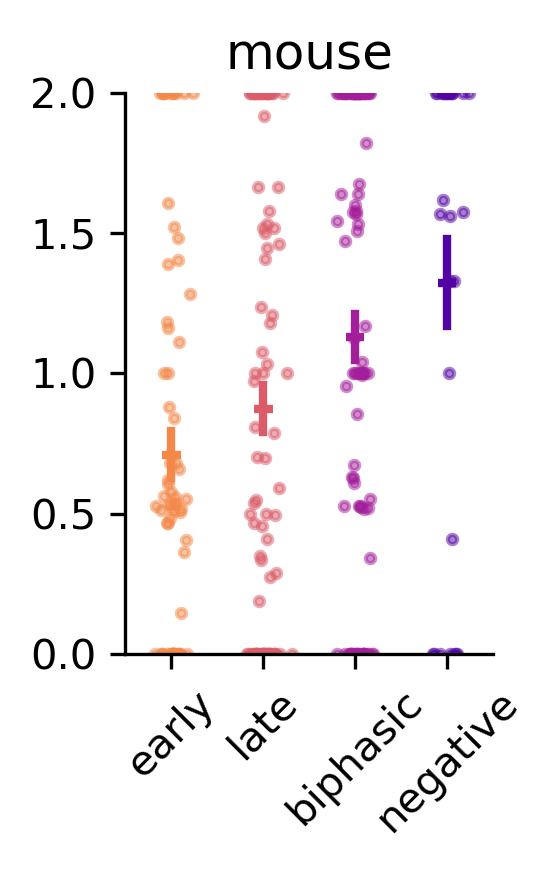

In [16]:
fig, ax = plt.subplots(1,1, figsize=(2,3), dpi=300)

for k, kname in enumerate(k_list):
    _show_means = gaus_fits[kname][:,0,1].copy()
    _show_means[_show_means<0] = 0
    _show_means[_show_means>2] = 2

    _jitter_x = np.ones(len(_show_means))*k + np.random.normal(0,0.1,len(_show_means))
    ax.scatter(_jitter_x, _show_means,
                color=kcolors[kname], alpha=0.5, s=5)
    
    _mean = np.nanmean(_show_means)
    _stderr = np.nanstd(_show_means) / np.sqrt(np.sum(~np.isnan(_show_means)))

    ax.hlines(_mean, k-.1, k+.1, color=kcolors[kname], lw=2)
    ax.plot([k,k], [_mean-_stderr, _mean+_stderr], '-', color=kcolors[kname], lw=2)

ax.set_xlim([-.5,3.5])
ax.set_ylim([0,2])
ax.set_xticks(range(4), labels=k_list, rotation=45)
ax.set_title('mouse')

fig.tight_layout()
# fig.savefig('mouse_gauss_means_summary.pdf')



In [42]:
# do a regression on dEye and dPhi
from scipy.stats import linregress


In [47]:
use = (~np.isnan(dEye_data)) * (~np.isnan(dPhi_data))
use = use * (np.abs(dEye_data)>150) * (np.abs(dPhi_data)>150)
res = linregress(dEye_data[use], dPhi_data[use])
print(res)

LinregressResult(slope=0.8675610454762634, intercept=43.84083699467567, rvalue=0.7124808582547348, pvalue=0.0, stderr=0.008287953660655933, intercept_stderr=2.814495249719532)


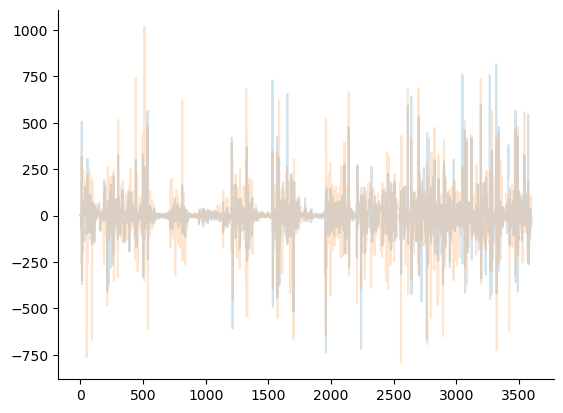

In [38]:
plt.plot(dPhi_data[:3600], alpha=0.2)
plt.plot(dEye_data[:3600], alpha=0.2)


In [4]:
plt.hist(dPhi_data)

NameError: name 'dPhi_data' is not defined

Text(0, 0.5, 'dPhi (deg)')

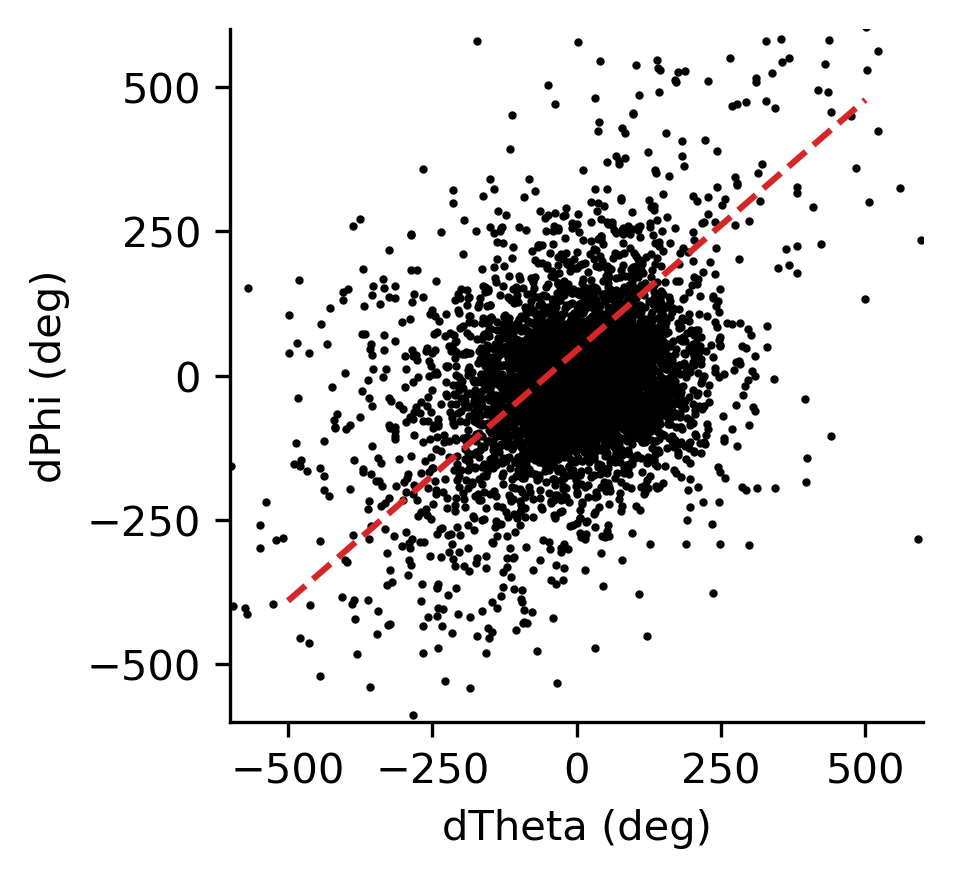

In [48]:
fig, ax = plt.subplots(1,1,figsize=(3,3),dpi=300)
ax.scatter(dEye_data[::25], dPhi_data[::25], s=1, color='k')
ax.set_aspect('equal','box')
ax.set_ylim([-600,600])
ax.set_xlim([-600,600])
ax.set_yticks(range(-500,501,250))
ax.plot(np.linspace(-500,500), res.intercept + res.slope*np.linspace(-500,500), '--', color='tab:red')
ax.set_xlabel('dTheta (deg)')
ax.set_ylabel('dPhi (deg)')

In [7]:
_all_stune.shape

(29, 3)

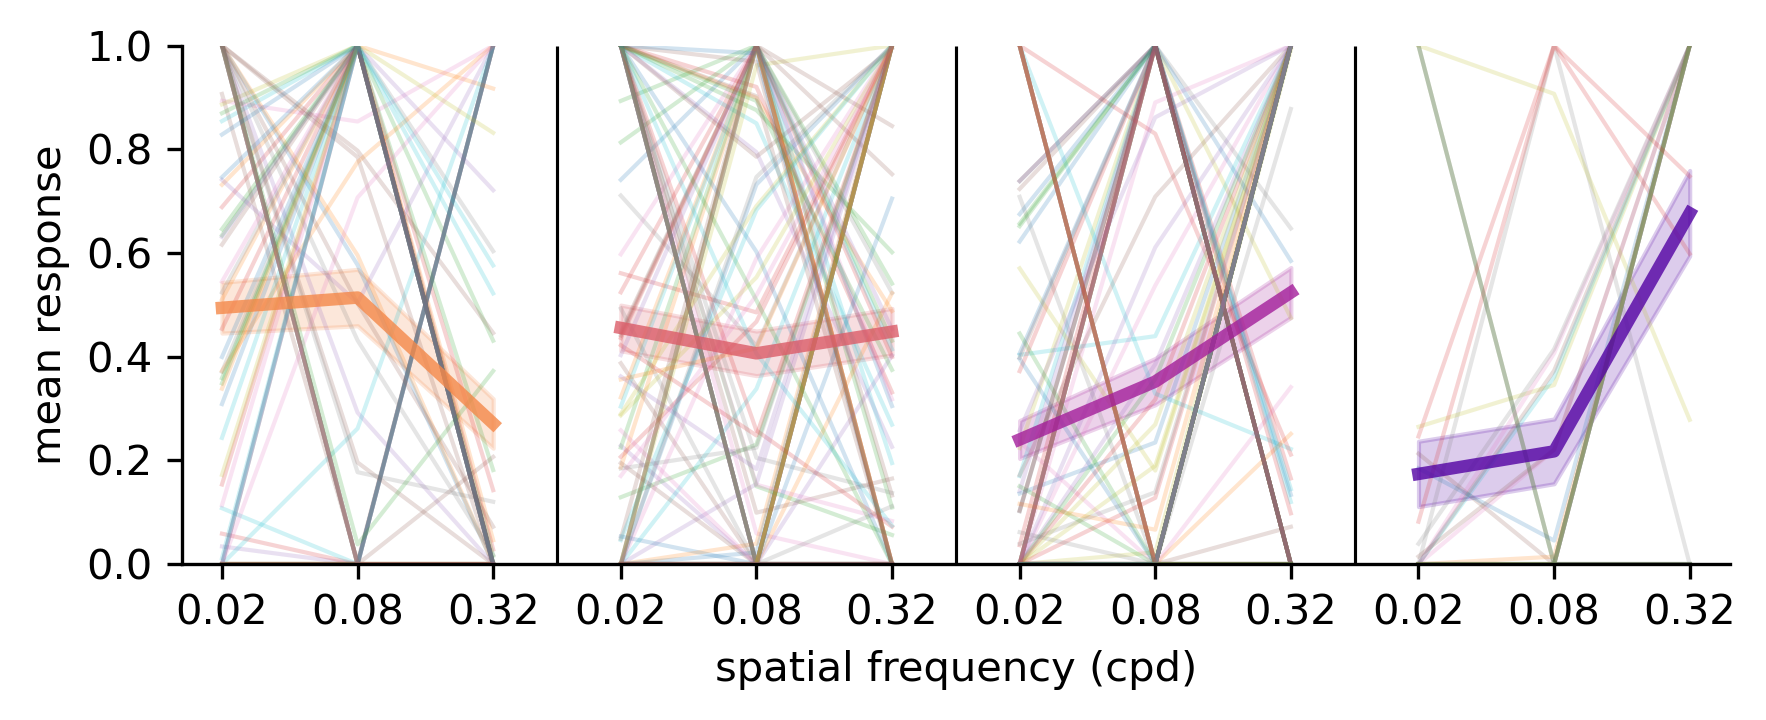

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,2.5), dpi=300)

_means_for_anova = np.zeros([4,3])

_all_other_stune = np.zeros([0,3])

all_x_positions = []

for k, kname in enumerate(k_list):

    _all_stune = gaus_inputs[kname]['sf']

    _show_mean = np.nanmean(_all_stune, axis=0)
    _show_stderr = np.nanstd(_all_stune, axis=0) / np.sqrt(np.sum(~np.isnan(_all_stune), axis=0))

    x_positions = [k, k+0.34, k+0.68]
    all_x_positions += x_positions

    for i in range(np.size(_all_stune,0)):
        ax.plot(x_positions, _all_stune[i,:],
                alpha=0.2, lw=1)

    if k != 0:
        ax.vlines(k-.16, 0, 1, color='k', lw=.75)

    ax.plot(x_positions, _show_mean,
                    color=kcolors[kname], label=kname, lw=3, alpha=0.8)
    ax.fill_between(x_positions, _show_mean+_show_stderr, _show_mean-_show_stderr,
                    color=kcolors[kname], alpha=0.2)

    _means_for_anova[k,:] = _show_mean
    
x_labels = []
for k in range(4):
    x_labels += ['0.02', '0.08', '0.32']
# _show_oth_mean = np.nanmean(_all_other_stune, axis=0)
# _show_oth_stderr = np.nanstd(_all_other_stune, axis=0) / np.sqrt(np.sum(~np.isnan(_all_other_stune), axis=0))

# ax.plot(range(3), _show_oth_mean,
#                 color='grey', label='not early', lw=3, alpha=0.5)
# ax.fill_between(range(3), _show_oth_mean+_show_oth_stderr,
#                 _show_oth_mean - _show_oth_stderr,
#                 color='grey', lw=1, alpha=0.5)
        

# ax.legend()
ax.set_xlim([-.1, 3.78])
ax.set_ylim([0,1])
ax.set_xticks(all_x_positions, labels=x_labels)
ax.set_xlabel('spatial frequency (cpd)')
ax.set_ylabel('mean response')
# ax.set_title('mouse')

fig.tight_layout()
# fig.savefig('mouse_mean_tuning_SF.pdf')

In [13]:
from scipy.stats import f_oneway

In [34]:
f_results = np.zeros([4,2])
for k, name in enumerate(['early','late','biphasic','negative']):
    res = f_oneway(gaus_inputs[name]['sf'])
    f_results[k,:] = np.array([res.statistic, res.pvalue])

TypeError: at least two inputs are required; got 1.

In [31]:
gaus_inputs['early']['sf']

array([[1.        , 0.57684326, 0.        ],
       [0.51029079, 1.        , 0.04617433],
       [0.64597164, 1.        , 0.43083017],
       [0.68844199, 1.        , 0.14266796],
       [0.03415451, 0.        , 1.        ],
       [0.90660865, 0.00438555, 1.        ],
       [0.89335177, 0.85342797, 1.        ],
       [0.37107292, 1.        , 0.60344974],
       [0.88654312, 1.        , 0.        ],
       [0.85419141, 1.        , 0.        ],
       [0.30867337, 1.        , 0.        ],
       [1.        , 0.59548363, 0.        ],
       [0.63405466, 1.        , 0.00423017],
       [0.0588224 , 0.        , 1.        ],
       [1.        , 0.29225475, 0.        ],
       [1.        , 0.79709861, 0.44566705],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        ],
       [0.10791234, 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.73151485, 1.        , 0.91696648],
       [0.

In [21]:
print(res.statistic, '\n', res.pvalue)

[9.56634464 3.75679864 7.16664488] 
 [4.82307173e-06 1.13225489e-02 1.17188624e-04]


In [77]:
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

In [36]:
gaus_inputs['early']['sf'].shape

(71, 3)

In [71]:
np.nanmean(gaus_inputs['early']['sf'], axis=0)
np.nanmean(gaus_inputs['late']['sf'], axis=0)
np.nanmean(gaus_inputs['biphasic']['sf'], axis=0)
np.nanmean(gaus_inputs['negative']['sf'], axis=0)

array([0.17397084, 0.21749447, 0.67670447])

In [93]:
res = f_oneway(gaus_inputs['early']['sf'],
         gaus_inputs['late']['sf'],
         gaus_inputs['biphasic']['sf'],
         gaus_inputs['negative']['sf'], axis=0)
# print(np.nanmean(gaus_inputs['early']['sf'], axis=0), '\n',
#          np.nanmean(gaus_inputs['late']['sf'], axis=0), '\n',
#          np.nanmean(gaus_inputs['biphasic']['sf'], axis=0), '\n',
#          np.nanmean(gaus_inputs['negative']['sf'], axis=0))
print(res)

F_onewayResult(statistic=array([9.56634464, 3.75679864, 7.16664488]), pvalue=array([4.82307173e-06, 1.13225489e-02, 1.17188624e-04]))


In [4]:
sf_input = np.array([np.array(gaus_inputs['early']['sf']),
            np.array(gaus_inputs['late']['sf']),
            np.array(gaus_inputs['biphasic']['sf']),
            np.array(gaus_inputs['negative']['sf'])])
np.save('mouse_sf', sf_input)

In [5]:
tf_input = np.array([np.array(gaus_inputs['early']['tf']),
            np.array(gaus_inputs['late']['tf']),
            np.array(gaus_inputs['biphasic']['tf']),
            np.array(gaus_inputs['negative']['tf'])])
np.save('mouse_tf', tf_input)

In [94]:
from statsmodels.multivariate.manova import MANOVA

In [106]:
MANOVA.fit(sf_input)

NotImplementedError: fit is not needed to use MANOVA. Callmv_test directly on a MANOVA instance.

In [82]:
1.13225489e-02

0.0113225489

In [80]:
tf_inputs = np.arrauynp.nanmean(gaus_inputs['early']['tf'], axis=0),
         np.nanmean(gaus_inputs['late']['tf'], axis=0),
         np.nanmean(gaus_inputs['biphasic']['tf'], axis=0),
         np.nanmean(gaus_inputs['negative']['tf'], axis=0))

F_onewayResult(statistic=0.04789389070007706, pvalue=0.9841936457569429)

In [63]:
anova_input

(4, 3)

F_onewayResult(statistic=0.1623964470164223, pvalue=0.9186941500013349)

In [29]:
_means_for_anova

array([[0.49432346, 0.514058  , 0.27121027],
       [0.45544137, 0.40645667, 0.44824712],
       [0.2403538 , 0.35200436, 0.5238326 ],
       [0.17397084, 0.21749447, 0.67670447]])

In [39]:
_means_for_anova[0,:]

array([0.49432346, 0.514058  , 0.27121027])

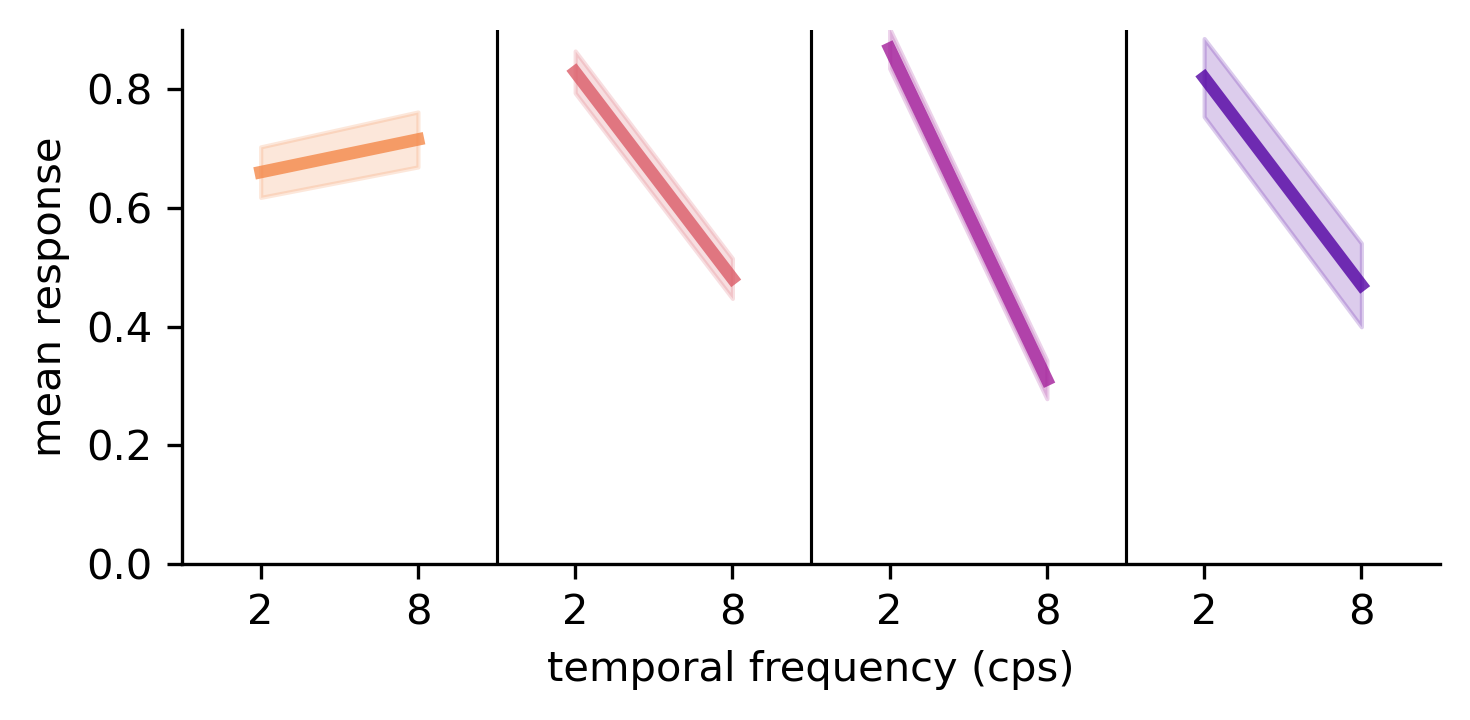

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5,2.5), dpi=300)

_all_other_stune = np.zeros([0,3])

all_x_positions = []

for k, kname in enumerate(k_list):

    _all_stune = gaus_inputs[kname]['tf']

    _show_mean = np.nanmean(_all_stune, axis=0)
    _show_stderr = np.nanstd(_all_stune, axis=0) / np.sqrt(np.sum(~np.isnan(_all_stune), axis=0))

    x_positions = [k, k+0.5]
    all_x_positions += x_positions

    if k != 0:
        ax.vlines(k-.25, 0, 1, color='k', lw=.75)

    ax.plot(x_positions, _show_mean,
                    color=kcolors[kname], label=kname, lw=3, alpha=0.8)
    ax.fill_between(x_positions, _show_mean+_show_stderr, _show_mean-_show_stderr,
                    color=kcolors[kname], alpha=0.2)

    # if k>0:
    #     _all_other_stune = np.concatenate([_all_other_stune, _all_stune], axis=0)

    # if k>0:
    #     _all_other_stune = np.concatenate([_all_other_stune, _all_stune], axis=0)
    
x_labels = []
for k in range(4):
    x_labels += ['2', '8']
# _show_oth_mean = np.nanmean(_all_other_stune, axis=0)
# _show_oth_stderr = np.nanstd(_all_other_stune, axis=0) / np.sqrt(np.sum(~np.isnan(_all_other_stune), axis=0))

# ax.plot(range(3), _show_oth_mean,
#                 color='grey', label='not early', lw=3, alpha=0.5)
# ax.fill_between(range(3), _show_oth_mean+_show_oth_stderr,
#                 _show_oth_mean - _show_oth_stderr,
#                 color='grey', lw=1, alpha=0.5)
        

# ax.legend()
ax.set_xlim([-.25, 3.75])
ax.set_ylim([0,.9])
ax.set_xticks(all_x_positions, labels=x_labels)
ax.set_xlabel('temporal frequency (cps)')
ax.set_ylabel('mean response')
# ax.set_title('mouse')

fig.tight_layout()
fig.savefig('mouse_mean_tuning_TF.pdf')